In [2]:
# import standard libraries
import numpy as np

# import helper functions
import helper as hp
import prep_data as pd
import read_data as rd
import mpnn as mp

# import RDKit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import DataStructs

# graph libraries
import networkx as nx
import periodictable as pt

# import pytorch
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

In [3]:
import mpnn as mp

# CROSS VALIDATION PARAMETERS from hyperparameter tuning
ONE_HOT_ENC_ATOMIC_NUM = True
LR = 0.01
BATCH_SIZE = 64
EPOCHS = 100

if ONE_HOT_ENC_ATOMIC_NUM:
    IN_CHANNELS = 123
else:
    IN_CHANNELS = 6

HIDDEN_CHANNELS = 64
OUT_CHANNELS = 3
NUM_LAYERS = 5

In [20]:
# shuffle the data and seed it
model = mp.MPNN(in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_layers=NUM_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

data_list, smis = rd.read_pyg_and_smi_data_from_file('data.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)
mp.train_loop(data_list, model, optimizer, num_epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)

Epoch 0, Train Loss: 0.04713404442855092, Val Loss: 0.022725653648376466
Epoch 1, Train Loss: 0.019152464063534904, Val Loss: 0.01594653706997633
Epoch 2, Train Loss: 0.01371899756148111, Val Loss: 0.012317207455635071
Epoch 3, Train Loss: 0.01014237014880014, Val Loss: 0.010251674242317677
Epoch 4, Train Loss: 0.008953090800448905, Val Loss: 0.008579129166901112
Epoch 5, Train Loss: 0.008402492558626934, Val Loss: 0.008385023474693299
Epoch 6, Train Loss: 0.008117039525491554, Val Loss: 0.007337889075279236
Epoch 7, Train Loss: 0.007845548046536224, Val Loss: 0.0068921026773750785
Epoch 8, Train Loss: 0.0074390602233104924, Val Loss: 0.00806871075183153
Epoch 9, Train Loss: 0.007557427294032518, Val Loss: 0.007202512584626675
Epoch 10, Train Loss: 0.0074491022956059425, Val Loss: 0.0075192623771727085
Epoch 11, Train Loss: 0.007230918627059044, Val Loss: 0.007624464482069016
Epoch 12, Train Loss: 0.00714049605262834, Val Loss: 0.007429191656410694
Epoch 13, Train Loss: 0.0071153674859

In [21]:
validation, smi_val = rd.read_pyg_and_smi_data_from_file('validation_masked.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)
solvent, smi_solv = rd.read_pyg_and_smi_data_from_file('solvent_masked.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)
permutation, smi_perm = rd.read_pyg_and_smi_data_from_file('permutation_masked.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)
josh, smi_josh = rd.read_pyg_and_smi_data_from_file('josh_masked.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)

In [9]:
def predict_mass(atomic_number: int):
    """
    Predict the mass of an atom based on its atomic number.
    """
    return pt.elements[atomic_number].mass

def predict_masses(atomic_numbers: np.ndarray):
    """
    Predict the masses of atoms based on their atomic numbers.
    """
    return np.array([predict_mass(atomic_number) for atomic_number in atomic_numbers]) 

def mpnn_predict(data_loader, model):
    model.eval()
    y_pred = []
    for data in data_loader:
        out = model(data)

        atomic_num = data.x[:, :118].cpu().numpy().argmax(axis=1)
        mass_pred = predict_masses(atomic_num)

        # append the predicted mass to the output
        out = np.concatenate((mass_pred[:, None], out.cpu().detach().numpy()), axis=1)
        y_pred.append(out)
    return y_pred

def mpnn_predict_no_mass_with_labels(data_loader: DataLoader, model):
    model.eval()

    all_predictions = []
    all_true_labels = []
    for data in data_loader:
        with torch.no_grad():
            out = model(data)
        
        all_predictions.append(out)
        all_true_labels.append(data.y)

    # Concatenate predictions and true labels from all batches
    all_predictions = torch.cat(all_predictions, dim=0)
    all_true_labels = torch.cat(all_true_labels, dim=0)
    return all_predictions, all_true_labels

def add_preds_to_nx_graph(graphs: dict[str: nx.Graph], y_pred: dict[str: torch.Tensor]):
    """
    Add the predicted masses to the data dictionary.
    """
    # add the predicted outputs to the "param" attribute of the nodes
    for key, graph in graphs.items():
        for node in graph.nodes:
            graph.nodes[node]['param'] = {
                "mass": y_pred[key][node][0],
                "charge": y_pred[key][node][1],
                "sigma": y_pred[key][node][2],
                "epsilon": y_pred[key][node][3]
            }

In [24]:
validation_loader = DataLoader(validation, batch_size=1, shuffle=False)
solvent_loader = DataLoader(solvent, batch_size=1, shuffle=False)
permutation_loader = DataLoader(permutation, batch_size=1, shuffle=False)
josh_loader = DataLoader(josh, batch_size=1, shuffle=False)

# validation
print('Validation')
pred_val = mpnn_predict(validation_loader, model)
pred_val_dict = {smi: pred for smi, pred in zip(smi_val, pred_val)}

# solvent
print('Solvent')
pred_solv = mpnn_predict(solvent_loader, model)
pred_solv_dict = {smi: pred for smi, pred in zip(smi_solv, pred_solv)}

# permutation
print('Permutation')
pred_perm = mpnn_predict(permutation_loader, model)
pred_perm_dict = {smi: pred for smi, pred in zip(smi_perm, pred_perm)}

# josh
print('Josh')
pred_josh = mpnn_predict(josh_loader, model)
pred_josh_dict = {smi: pred for smi, pred in zip(smi_josh, pred_josh)}

Validation
Solvent
Permutation
Josh


In [25]:
validation_nx, smi_val_nx = rd.read_nx_and_smi_data_from_file('validation_masked.json')
validation_nx_dict = {smi: nx for smi, nx in zip(smi_val_nx, validation_nx)}

solvent_nx, smi_solv_nx = rd.read_nx_and_smi_data_from_file('solvent_masked.json')
solvent_nx_dict = {smi: nx for smi, nx in zip(smi_solv_nx, solvent_nx)}

permutation_nx, smi_perm_nx = rd.read_nx_and_smi_data_from_file('permutation_masked.json')
permutation_nx_dict = {smi: nx for smi, nx in zip(smi_perm_nx, permutation_nx)}

josh_nx, smi_josh_nx = rd.read_nx_and_smi_data_from_file('josh_masked.json')
josh_nx_dict = {smi: nx for smi, nx in zip(smi_josh_nx, josh_nx)}

add_preds_to_nx_graph(validation_nx_dict, pred_val_dict)
add_preds_to_nx_graph(solvent_nx_dict, pred_solv_dict)
add_preds_to_nx_graph(permutation_nx_dict, pred_perm_dict)
add_preds_to_nx_graph(josh_nx_dict, pred_josh_dict)

In [28]:
josh_nx_dict['92eb98c20da89676c961'].nodes[0]

{'atomic': 6,
 'valence': 4,
 'formal_charge': 0,
 'aromatic': False,
 'hybridization': 4,
 'radical_electrons': 0,
 'param': {'mass': 12.0107,
  'charge': -0.018911005929112434,
  'sigma': 0.2901749014854431,
  'epsilon': 0.27008384466171265}}

In [30]:
# write the graphs to file
hp.write_data_to_json_file(validation_nx_dict, './preds/validation_masked_preds.json')
hp.write_data_to_json_file(solvent_nx_dict, './preds/solvent_masked_preds.json')
hp.write_data_to_json_file(permutation_nx_dict, './preds/permutation_masked_preds.json')
hp.write_data_to_json_file(josh_nx_dict, './preds/josh_masked_preds.json')

## Testing Model

### Training only on 80% of the data and testing on the remaining 20% of the data
Using the hyperparameters found in the **cross-validation step**, we will train the model on 80% of the data and test on the remaining 20% of the data.

In [4]:
model = mp.MPNN(in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_layers=NUM_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

data_list, smis = rd.read_pyg_and_smi_data_from_file('data.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)

train_list = data_list[:int(0.8*len(data_list))]
test_list = data_list[int(0.8*len(data_list)):]

mp.train_loop(train_list, model, optimizer, num_epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)

Epoch 0, Train Loss: 0.04426527231493417, Val Loss: 0.022979488596320152
Epoch 1, Train Loss: 0.019044214256984347, Val Loss: 0.015892108902335167
Epoch 2, Train Loss: 0.013211652554352494, Val Loss: 0.011283479863777757
Epoch 3, Train Loss: 0.01001114332500626, Val Loss: 0.009805758250877261
Epoch 4, Train Loss: 0.00895857171374647, Val Loss: 0.008967173751443624
Epoch 5, Train Loss: 0.008502939332495718, Val Loss: 0.008338627638295293
Epoch 6, Train Loss: 0.008362008751753499, Val Loss: 0.009005016414448619
Epoch 7, Train Loss: 0.007946621681399205, Val Loss: 0.0080824886681512
Epoch 8, Train Loss: 0.007620543008670211, Val Loss: 0.00857055326923728
Epoch 9, Train Loss: 0.007672022507690331, Val Loss: 0.0071121169021353126
Epoch 10, Train Loss: 0.007495697231634575, Val Loss: 0.006931540207006037
Epoch 11, Train Loss: 0.007169136448818094, Val Loss: 0.008265456417575479
Epoch 12, Train Loss: 0.007743220228482695, Val Loss: 0.006789984181523323
Epoch 13, Train Loss: 0.0071980752297403

In [12]:
test_loader = DataLoader(test_list, batch_size=1, shuffle=False)
pred_test, true_test = mpnn_predict_no_mass_with_labels(test_loader, model)

In [16]:
pred_test = pred_test.cpu().detach().numpy()
true_test = true_test.cpu().detach().numpy()

pred_charges = pred_test[:, 0]
true_charges = true_test[:, 0]

pred_sigma= pred_test[:, 1]
true_sigma = true_test[:, 1]

pred_eps = pred_test[:, 2]
true_eps = true_test[:, 2]

In [33]:
# configure the plot style
import matplotlib.pyplot as plt

# set the rcParams
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6

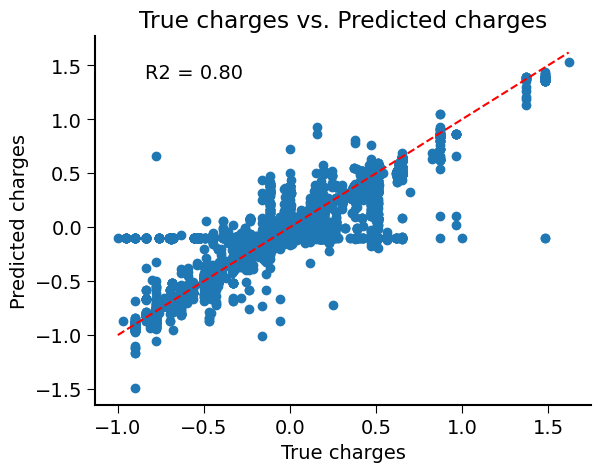

In [35]:

# compute the correlation coefficient
r = np.corrcoef(true_charges, pred_charges)[0, 1]

# add the correlation coefficient to the plot
plt.text(0.2, 0.9, f'R2 = {r**2:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

plt.scatter(true_charges, pred_charges)
plt.xlabel('True charges')
plt.ylabel('Predicted charges')
plt.title('True charges vs. Predicted charges')

# draw a dashed line to represent the ideal case
max_x = np.max(true_charges)
min_x = np.min(true_charges)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()

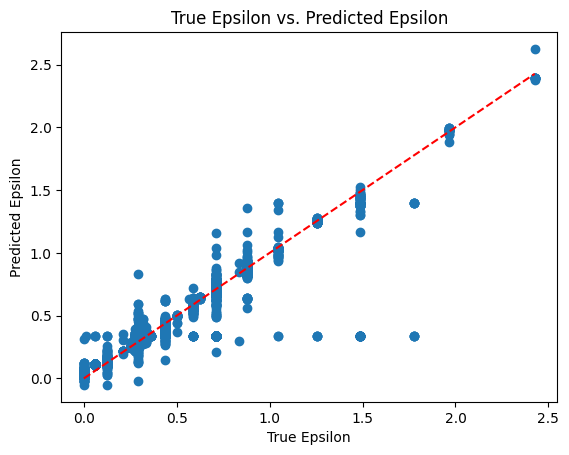

In [19]:
plt.scatter(true_eps, pred_eps)
plt.xlabel('True Epsilon')
plt.ylabel('Predicted Epsilon')
plt.title('True Epsilon vs. Predicted Epsilon')

# draw a dashed line to represent the ideal case
max_x = np.max(true_eps)
min_x = np.min(true_eps)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()

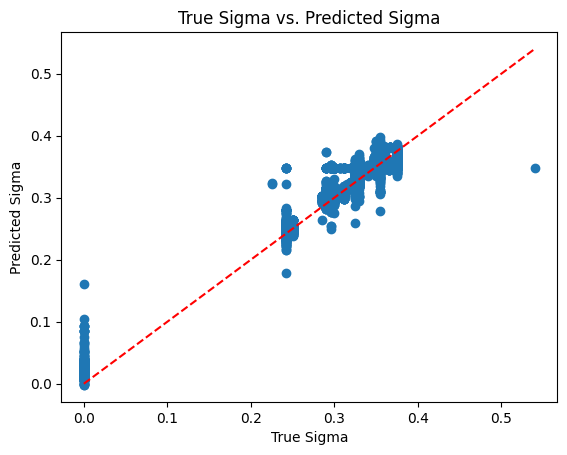

In [20]:
plt.scatter(true_sigma, pred_sigma)
plt.xlabel('True Sigma')
plt.ylabel('Predicted Sigma')
plt.title('True Sigma vs. Predicted Sigma')

# draw a dashed line to represent the ideal case
max_x = np.max(true_sigma)
min_x = np.min(true_sigma)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()